### Convnet filters

#### Another way to analyse features learned by convnets is to display each visual pattern that maximizes the activation of specific filters
    * This is done with gradient ascent
        * Apply gradient descent to an input image in order to maximize the response of a given filter

In [3]:
from keras.applications import VGG16
from keras import backend as K
import tensorflow as tf

gpu_fraction = 0.1
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

model = VGG16(weights='imagenet',
              include_top=False)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    x += 0.5
    x = np.clip(x, 0, 1)

    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [116]:
def generate_pattern(layer_name, filter_index, size=56):
    layer_output = model.get_layer(layer_name).output
    input_img_data = np.random.uniform(180, 150, (1, size, size, 3))/255
    step = 1.
    for _ in range(12):
        loss = K.mean(layer_output[:, :, :, filter_index])  # specify a loss function with respect to output of a filter
        grads = K.gradients(loss, model.input)[0]  # creates a function that computes the gradients between the loss and the input
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)  # divide the tensor by its L2 norm in order to smooth the gradient descent process
        iterate = K.function([model.input], [loss, grads])  #  finally compute the loss and gradient given an input
        for i in range(20):  # step added by me to upscale images
            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step
        input_img_data = upscale_image(input_img_data)

    img = input_img_data[0]
    return deprocess_image(img)

In [16]:
from matplotlib import pyplot as plt

In [29]:
import cv2
import numpy as np
def upscale_image(img, upscaling_factor=1.2, blur=5):
    new_size =  int(upscaling_factor * img.shape[1])
    new_img = cv2.resize(img[0], (new_size, new_size), interpolation=cv2.INTER_CUBIC)
    if blur: 
        new_img = cv2.blur(new_img, (blur, blur))
    return np.expand_dims(new_img, axis=0)

#### The next few cells show us that, as mentioned in the notebook visualising_convenets_layers_output, first layers tend to maximize its response to edges, as you go higher layers start to learn textures, to finally, in the last layers learn complex shapes. 

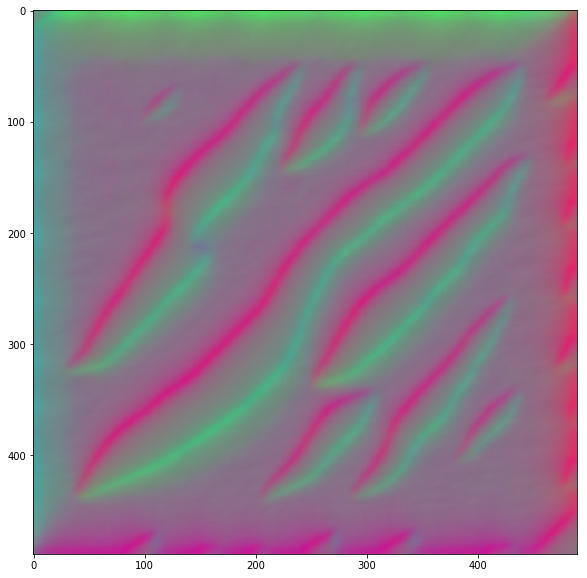

In [117]:
img = generate_pattern('block2_conv1', 56)
plt.figure(figsize=(10, 10))
plt.imshow(img)

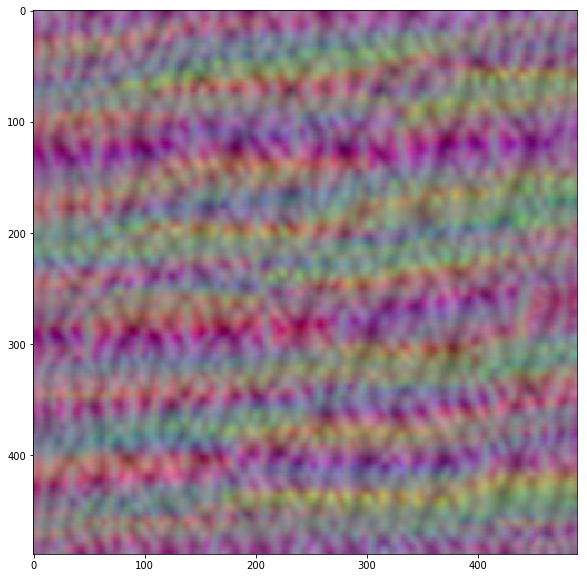

In [121]:
img = generate_pattern('block3_conv2', 128)
plt.figure(figsize=(10, 10))
plt.imshow(img)

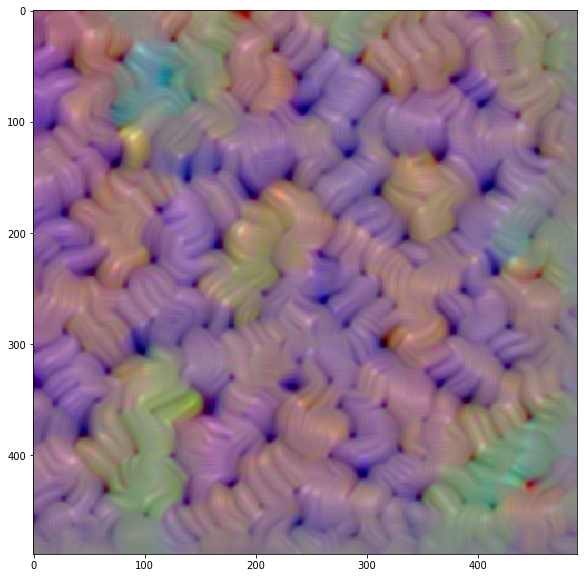

In [124]:
img = generate_pattern('block4_conv2', 212)
plt.figure(figsize=(10, 10))
plt.imshow(img)

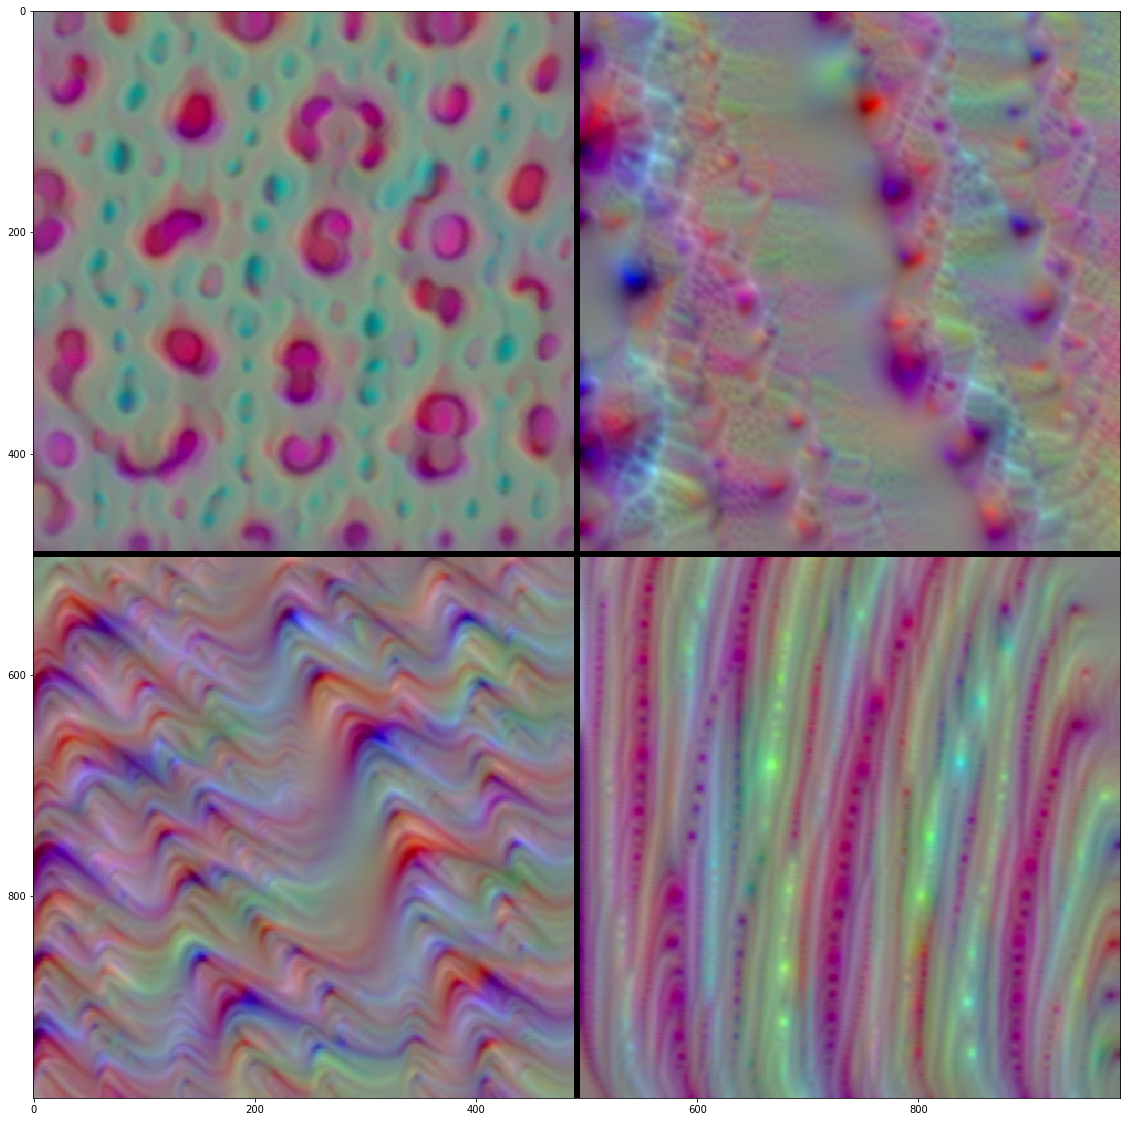

In [126]:
layer_name = 'block4_conv1'
size = 489
margin = 5

results = np.zeros(
    (2 * 489 + margin, 2 * 489 + margin, 3),
    dtype='uint8'
)

for i in range(2):
    for j in range(2):
        filter_img = generate_pattern(layer_name, i + (j * 2), size=56)

        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end,
                vertical_start: vertical_end, :] = filter_img

plt.figure(figsize=(20, 20))
plt.imshow(results)